In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
def plot_synthetic_data2(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)


    ax[3].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [4]:
def plot_synthetic_data(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[4].plot(x, lams[:,2,l], color=trial_color)
    ax[4].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[4].margins(0)
    ax[4].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)

    ax[5].plot(x, obs[:,2,l], color=trial_color)
    ax[5].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[5].margins(0)
    ax[5].set_ylabel('Intensity', size = label_size)


    ax[5].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [5]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

In [6]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [7]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [9]:
num_iters = 20

lcfg_attrs = {'gamma': 'k3-temp-rank1-nz9'}

mcfg_attrs = {'emiters': num_iters,
              'init': 'empirical-init'}

ocfg_attrs = {'obs_type': 'pp_relu'}

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-19']

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
alphas = sorted([r['cfg'].obs.alpha for r in res_load])


3 paths found meeting critera


In [10]:
alphas

[100, 300, 500]

In [11]:
alpha = 100
L = 25
lsel = {'L': L}
msel = {'emiters': num_iters,
              'init': 'empirical-init'}
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, {}, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz = res['params']['nonzero_inds']

Returned single result.


In [12]:
from cohlib.jax.dists import naive_estimator, sample_ccn_rank1
from cohlib.jax.simtools import load_gamma


naive_ests = {}
oracle_ests = {}
for alpha in alphas:
    osel = {'alpha': alpha}
    res = filter_loaded(res_load, lsel, msel, osel)

    
    cfg = res['cfg']
    lcfg = cfg.latent
    ocfg = cfg.obs
    gamma_true = res['gamma_true_full']
    K = gamma_true.shape[-1]

    gamma_load = load_gamma(cfg)
    nz_target = gamma_load['target_inds']
    eigvec = gamma_load['eigvec']
    eigval = gamma_load['eigval']

    lrk = jr.key(lcfg.seed)

    zs_target = sample_ccn_rank1(lrk, eigvec, eigval, K, lcfg.L)
    gamma_full_dummytarget = gamma_true.copy()
    gamma_full_dummytarget = gamma_full_dummytarget.at[nz_target,:,:].set(jnp.eye(K, dtype=complex))

    zs = sample_from_gamma(lrk, gamma_full_dummytarget, lcfg.L)
    zs = zs.at[nz_target,:,:].set(zs_target)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)
    params = jnp.array([ocfg.alpha for _ in range(K)])
    print(params)
    lams = cif_alpha_relu(params, xs)


    obs, obs_params = sample_obs(ocfg, xs)
    naive_est = naive_estimator(obs, nz)
    naive_ests[alpha] = naive_est * 1e6

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)
    oracle_ests[alpha] = gamma_oracle

Returned single result.
[100 100 100]
Returned single result.
[300 300 300]
Returned single result.
[500 500 500]


In [24]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind_full,i,j].real] + [gamma_r[j_ind,i,j].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind_full,i,j].imag] + [gamma_r[j_ind,i,j].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

def plot_cross_spec_func_em_iters(ax, func, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None, color='tab:blue'):
    cs_real = jnp.array([func(gamma_init[j_ind_full,i,j])] + [func(gamma_r[j_ind,i,j]) for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color=color, linewidth=2)

In [25]:
alpha = 100
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, msel, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz = res['params']['nonzero_inds']

Returned single result.


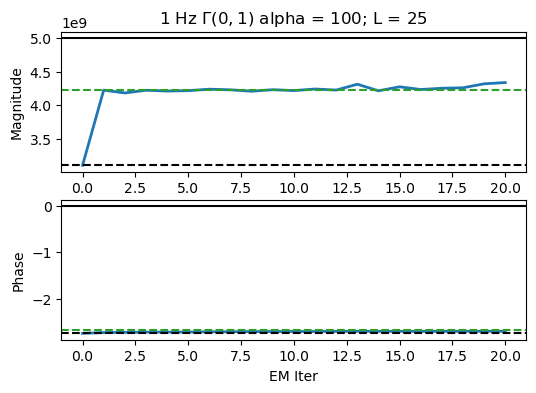

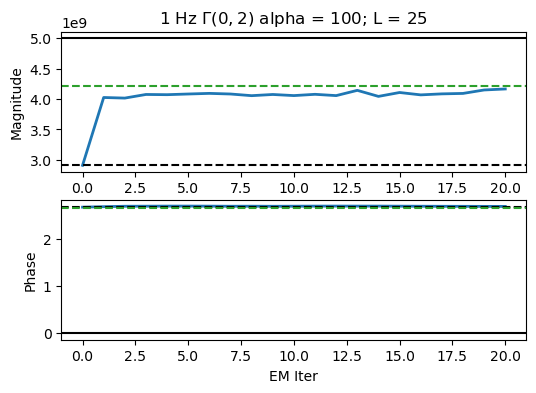

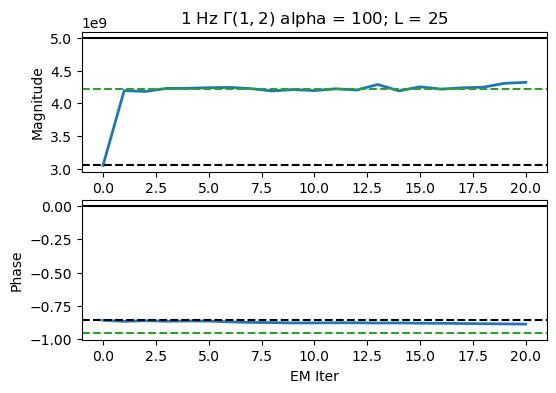

In [27]:
jind = 0 
jind_full = 9
i = 1
j = 2
ijs = [[0,1], [0,2], [1,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(2,1, figsize=(6,4))
    func = jnp.abs
    plot_cross_spec_func_em_iters(ax[0], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax[0].axhline(func(res['gamma_true_full'][jind_full,i,j]), color='k')
    ax[0].axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax[0].axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax[0].set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax[0].set_ylabel('Magnitude')

    func = jnp.angle
    plot_cross_spec_func_em_iters(ax[1], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax[1].axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax[1].axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax[1].axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax[1].set_ylabel('Phase')
    ax[1].set_xlabel('EM Iter')
    # ax[1].set_ylim([-3.14,3.14])


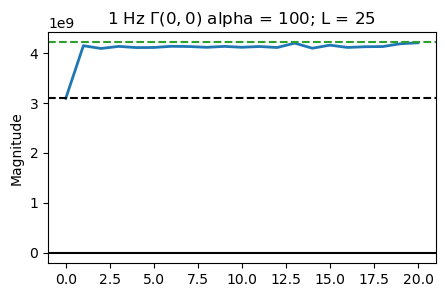

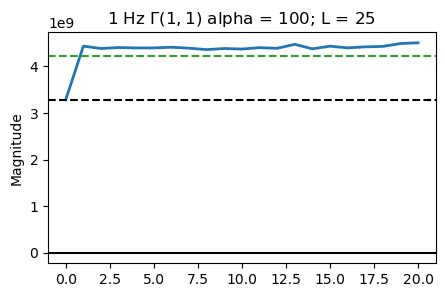

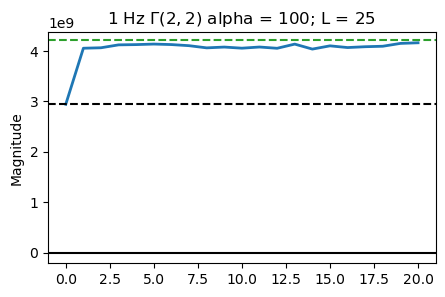

In [29]:
jind = 0
ijs = [[0,0], [1,1], [2,2]]

for ij in ijs:
    i, j = ij
    fig, ax = plt.subplots(figsize=(5,3))
    func = jnp.real
    plot_cross_spec_func_em_iters(ax, func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
    ax.axhline(func(res['gamma_true_full'][jind,i,j]), color='k')
    ax.axhline(func(naive_ests[alpha][jind,i,j]), linestyle='--', color='k')
    ax.axhline(func(oracle_ests[alpha][jind,i,j]), linestyle='--', color='tab:green')
    ax.set_title(f'{jind+1} Hz ' + rf'$\Gamma({i}, {j})$' + f' alpha = {alpha}; L = {L}')
    ax.set_ylabel('Magnitude')

In [31]:
def get_eigval(mat, rank):
    eigvals = jnp.linalg.eigh(mat)[0]
    return eigvals[-rank]

def get_eigvec(mat, rank):
    eigvecs = jnp.linalg.eigh(mat)[1]
    return eigvecs[:,-rank]

def plot_cross_spec_eigval_em_iters(ax, eigrank, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    eigs = jnp.array([get_eigval(gamma_init[j_ind,:,:], eigrank)] + [get_eigval(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    ax.plot(eigs, color='tab:blue', linewidth=2)

def get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    eigvecs = jnp.array([get_eigvec(gamma_init[j_ind,:,:], eigrank)] + [get_eigvec(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    return eigvecs

def plot_eigvec_func_em_iters(ax, func, eigrank, dim, gamma_iter_list, gamma_init, j_ind=9, nz=None, color='tab:blue'):
    eigvecs = get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind, nz=nz)
    res = func(eigvecs[:,dim])
    ax.plot(res, color=color, linewidth=2)

In [32]:
eigvec_true = gamma_load['eigvec']
eigval_true = gamma_load['eigval']
print(eigvec_true)

[-0.2997868 +0.49341786j  0.04743132-0.5753987j   0.49793887-0.29221603j]


In [33]:
test_eigvals, test_eigvecs = jnp.linalg.eigh(eigval * jnp.outer(eigvec_true, eigvec_true.conj()))
eigvec_posttrue = test_eigvecs[:,-1]
print(eigvec_posttrue)

[ 0.57735026+0.j         -0.51637846+0.2582375j  -0.50828785-0.27381894j]


In [35]:
gamma_naive = naive_ests[alpha]
gamma_oracle = oracle_ests[alpha]

eigvec_naive = get_eigvec(gamma_naive[9,:,:], 1)
eigvec_oracle = get_eigvec(gamma_oracle[9,:,:], 1)

eigval_naive = get_eigval(gamma_naive[9,:,:], 1)
eigval_oracle = get_eigval(gamma_oracle[9,:,:], 1)

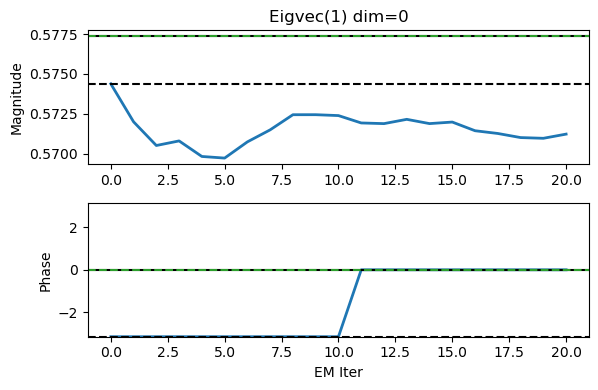

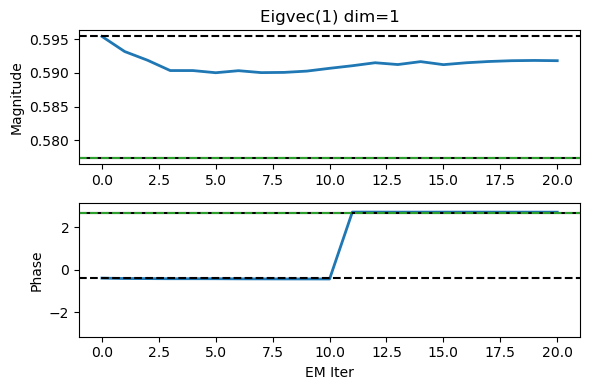

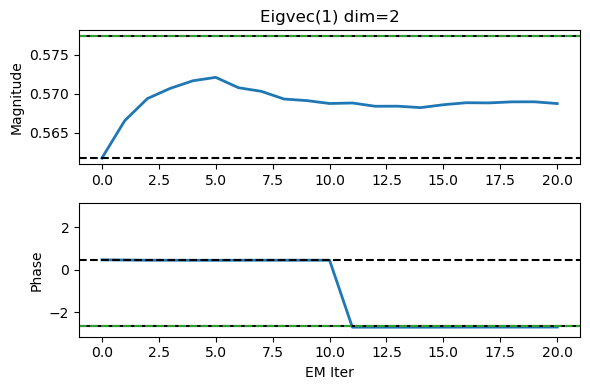

In [36]:
dims = jnp.arange(K)

for dim in dims:
    fig, ax = plt.subplots(2,1,figsize=(6,4))
    func=jnp.abs
    plot_eigvec_func_em_iters(ax[0], func, 1, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
    eigvec_true_use = eigvec_posttrue
    ax[0].axhline(func(eigvec_true_use[dim]), color='k')
    ax[0].axhline(func(eigvec_naive[dim]), linestyle='--', color='k')
    ax[0].axhline(func(eigvec_oracle[dim]), linestyle='--', color='tab:green')
    ax[0].set_ylabel('Magnitude')
    ax[0].set_title(f'Eigvec(1) dim={dim}')

    func = jnp.angle
    plot_eigvec_func_em_iters(ax[1], func, 1, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
    eigvec_true_use = eigvec_posttrue
    ax[1].axhline(func(eigvec_true_use[dim]), color='k')
    ax[1].axhline(func(eigvec_naive[dim]), linestyle='--', color='k')
    ax[1].axhline(func(eigvec_oracle[dim]), linestyle='--', color='tab:green')
    ax[1].set_ylim([-jnp.pi, jnp.pi])
    ax[1].set_ylabel('Phase')
    ax[1].set_xlabel('EM Iter')
    plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.


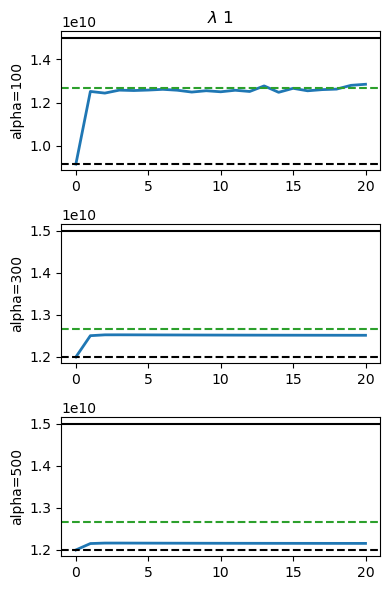

In [38]:
jind = 9
jind_full
eigrank = 1
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(3,1,figsize=(4,6))
for i, alpha in enumerate(alphas):
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)

        gamma_true = res['gamma_true_full']
        true_eigvals = jnp.linalg.eigh(gamma_true[jind_full,:,:])[0]

        gamma_naive = naive_ests[alpha]
        gamma_oracle = oracle_ests[alpha]
        oracle_eigvals = jnp.linalg.eigh(gamma_oracle[jind,:,:])[0]
        naive_eigvals = jnp.linalg.eigh(gamma_naive[jind,:,:])[0]

        nz = res['params']['nonzero_inds']
        plot_cross_spec_eigval_em_iters(ax[i], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[i].axhline(true_eigvals[-eigrank], color='k')
        ax[i].axhline(naive_eigvals[-eigrank], linestyle='--', color='k')
        ax[i].axhline(oracle_eigvals[-eigrank], linestyle='--', color='tab:green')
        if i == 0:
            ax[i].set_title(r'$\lambda$ ' f'{eigrank}')
        ax[i].set_ylabel(f'alpha={alpha}')
plt.tight_layout()